# Week 02 - Indexing 

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

In this tutorial we will learn about genome indexing with hash tables. You will implement a hash table that supports linear probing as a solution to hash collisions.
    
</div>

## Setup

**Week 2 workspace**

Ensure you have create a directory for week2 (eg <small>`~/COMP90014/tutorials/week2`</small>). <br>
Place this .ipynb file inside that directory (eg <small>`~/COMP90014/tutorials/week2/Week_02_Indexing.ipynb`</small>).

**Week 2 data**

This week we will be aligning a DNA read sequence to a viral genome. <br>
These need to be downloaded before we can use them. 

Read Sequence: <br>
https://github.com/melbournebioinformatics/COMP90014/blob/main/data/2023/Workshop_02/data/phi-X174-420bp.fa?raw=true

Genome Sequence: <br>
https://github.com/melbournebioinformatics/COMP90014/blob/main/data/2023/Workshop_02/data/phi-X174-genome.fa?raw=true 

We can use the <small>`wget`</small> and <small>`curl`</small> commands to download files via the command line. 
- <small>`wget [URL] -O [OUTFILE]`</small>
- <small>`curl -o [OUTFILE] [URL]`</small>

Where
- <small>`[URL]`</small> is the web address to access the file.
- <small>`[OUTFILE]`</small> is what we want the downloaded file to be named. <br><br>

<div style="font-size: 16px">

(Bash Shell)
> ```Bash
> # first, check you are in the week2 directory.
> pwd
> cd ~/COMP90014/tutorials/week2  # (change directory if required)
> 
> # next, create a 'data' directory for the data & change to that location 
> mkdir -p data
> cd data
> 
> # finally, download the data 
> wget https://github.com/melbournebioinformatics/COMP90014_2024/blob/main/data/2023/Workshop_02/data/phi-X174-420bp.fa?raw=true -O phi-X174-420bp.fa
> wget https://github.com/melbournebioinformatics/COMP90014_2024/blob/main/data/2023/Workshop_02/data/phi-X174-genome.fa?raw=true -O phi-X174-420bp.fa
> 
> ```

</div>

**Python environment**

Create a python environment for this tutorial. <br>
It should be located in your new 'week2' directory.

This week we need:
- ipykernel (if using VSC) or jupyterlab (if using Jupyter Lab) 
- requests
- biopython
- mmh3
- matplotlib

<div style="font-size: 16px">

(Bash Shell)
> ```Bash
> # check you are in the week2 directory.
> pwd
> cd ~/COMP90014/tutorials/week2  # (change directory if required)
> 
> # NOTE: 
> # the following command may return 'miniconda' | 'conda' etc in the python path. 
> # if so, first try to solve using `conda config --set auto_activate_base false` then restarting your shell. 
> # if unsuccessful, you can specify the exact python binary to use. 
> # a version of python should be present in /usr/bin, or /usr/local/bin.
> # for example /usr/bin/python, or /usr/bin/python3.10, or /usr/local/bin/python3.
> # on macOS, python may also be found at /Library/Frameworks/Python.framework/Versions/[version]/bin.
> # for example /Library/Frameworks/Python.framework/Versions/3.11/bin/python3.
> 
> # check your python is correct.
> which python 
> > /usr/bin/python
> python -V 
> > Python 3.11.5
>
> # use the venv module to create a virtualenv. 
> # calling `python -m venv` runs the venv module, and the final 'venv' specifies the name of the environment
> python -m venv venv
> 
> # activate the environment to begin working 
> # note: only activates in your current shell. if using VSC / Jupyter Lab, ensure you select it as the 'kernel'.
> source venv/bin/activate 
> 
> # check the environment is clean (should only list pip and setuptools)
> pip list 
> 
> # Install packages for this week. If using Jupyter Lab, swap 'ipykernel' for 'jupyterlab'.
> pip install ipykernel requests biopython mmh3 matplotlib
>
> # check the environment now has the required packages (should list a bunch of packages)
> pip list 
> 
> ```

</div>

**IDE setup**

Open your week 2 folder in VSC or Jupyter Lab.

VSC: 
1. Open VSC and load your week2 directory using "File" -> "Open Folder...". 
2. Open the .ipynb file and ensure the kernel is set to your new 'venv' environment for week2 (top right). 

Jupyter Lab: 
1. Open a shell and navigate to your week2 folder.
2. Activate your week2 python environment using <small>`source venv/bin/activate`</small>.
3. Run Jupyter Lab using <small>`jupyter lab`</small>.
4. Copy the returned localhost url & open in a web browser. 


In [2]:
import os
import requests
from IPython.core.display import HTML

# Handy function to fetch our data files
def fetch_file(url, outpath='.'):
    response = requests.get(url)
    if response.status_code == 200:
        print('File found!')
        # Get the filename from the URL
        filename = os.path.basename(url).split('?', 1)[0]
        # Construct the filepath using the specified directory and filename
        filepath = os.path.join(outpath, filename)
        # Create the directory if it doesn't exist
        if not os.path.exists(outpath):
            print(f'Creating output dir: {outpath}')
            os.makedirs(outpath)
        # Check if the file already exists in the specified directory
        if os.path.exists(filepath):
            print(f'{filename} already exists in {outpath}. Skip download.')
        else:
            with open(filepath, 'wb') as f:
                f.write(response.content)
                f.close()
            print(f'Saved to: {filepath}')
    else:
        print(f'File not found: Code {response.status_code}')

In [3]:
# Load stylesheet
HTML(requests.get('https://raw.githubusercontent.com/melbournebioinformatics/COMP90014/main/data/2023/style/custom.css').text)

### Load Packages

Optional: You can install murmurhash3, Murmurhash is a hashing algorithm that is commonly used in bioinformatics.

`pip install mmh3`

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
from Bio import SeqIO
from Bio.Seq import Seq
import mmh3

## Data 

Download the [genome of bateriophage PhiX](https://www.ncbi.nlm.nih.gov/nuccore/NC_001422.1/) as we as a sequencing 'read' from within the genome.

In [67]:
# Fetch test data
data = ['phi-X174-420bp.fa','phi-X174-genome.fa']

for filename in data:
    url = f'https://github.com/melbournebioinformatics/COMP90014/blob/main/data/2023/Workshop_02/data/{filename}?raw=true'
    print(url)
    # fetch_file(url,outpath='data')


https://github.com/melbournebioinformatics/COMP90014/blob/main/data/2023/Workshop_02/data/phi-X174-420bp.fa?raw=true
https://github.com/melbournebioinformatics/COMP90014/blob/main/data/2023/Workshop_02/data/phi-X174-genome.fa?raw=true


Next we will import these sequences using Biopython as SeqRecord objects. Explore the attributes of this object.
Where is the sequence stored?

In [7]:
# Import with biopython as seqrecord objects
phiX_read = SeqIO.read('data/phi-X174-420bp.fa', "fasta")
phiX_genome = SeqIO.read('data/phi-X174-genome.fa', "fasta")

If you wanted to manually read in a single fasta record as a string, you could do this:

In [8]:
# Or read it ourselves, assuming a file with one FASTA record
with open('data/phi-X174-genome.fa') as f:
    _identifier_row = f.readline()
    # Read the rest of the lines and join them into one string
    phiX = ''.join([row.strip() for row in f.readlines()])

Define some additional test strings.

In [9]:
Seq11 = Seq("CGTGCGTGCTT")
Seq25 = Seq("GTTATAGCTGATCGCGGCGTAGCGG")

# Generators and iterators

We're going to introduce a new kind of Python object - generators - in order to generate large number of strings without occupying a lot of memory.

You already know that we can iterate over lists:

In [10]:
for x in [1,3,5]:
    print(x)

1
3
5


We can also iterate over other data types, like sets and dicts. Any type we can iterate over is *iterable*.

*Generators* and *iterators* are special kinds of Python object that are iterable, but which don't need to store any contents in memory. Instead they calculate each value on request.

(A generator is a particular kind of iterator, but for this tutorial we are not going to worry about the difference between them.)

We can make an example iterator using `iter()` on a data structure:

In [51]:
number_iterator = iter([1,3,5])
print(number_iterator)

We can iterate over this just like the original list:

In [52]:
for x in number_iterator:
    print(x)

1
3
5


The built-in `next()` function gets the next value from an iterator

In [13]:
number_iterator = iter([1,3,5])

In [14]:
next(number_iterator)

1

In [15]:
next(number_iterator)

3

What do you think would happen if we ran our `for` loop now, i.e. tried to iterate with 

`for x in number_iterator` ?

In [16]:
for x in number_iterator:
    print(x)

5


More usefully, we can create a generator using a generator function. This means we never need to store all the objects in memory. A generator function is easy to recognise as it uses the `yield` keyword rather than the `return` keyword to return values.

Here's a (normal) function that returns a list of k-mers.

In [17]:
def get_kmers_list(text, k):
    ''' 
    Return a list of all k-mers of length k from string t.
    K-mers may be non-unique.
    '''
    result = []
    for i in range(len(text)-k+1):
        kmer = text[i:i+k]
        result.append(kmer)
    return result

In [18]:
get_kmers_list('BANANA', 3)

['BAN', 'ANA', 'NAN', 'ANA']

Here's a *generator function* that returns all the k-mers in the string, but only calculates each one as it is asked for. Every time the function reaches the `yield` keyword, it makes a new value available, which is consumed by whatever we are using to iterate, such as a `for` loop. At no point do we need to store the whole list of k-mers in memory!

In [19]:
def get_kmers_iterator(text, k):
    ''' 
    Return a generator yielding all k-mers of length k from string t.
    K-mers may be non-unique.
    '''
    for i in range(len(text)-k+1):
        kmer = text[i:i+k]
        yield kmer

Notice we yield the kmers one at a time. We don't try to return the whole list at once. There is no list!

Every time `next()` is called on our generator, either by a `for` loop or some other means, the function resumes running from where it left off and runs until it gets to a `yield` statement.

This gives us a generator, which is iterable:

In [20]:
for kmer in get_kmers_iterator('BANANA',3):
    print(kmer)

BAN
ANA
NAN
ANA


In [21]:
# There is no list
print(get_kmers_iterator('BANANA', 3))

<generator object get_kmers_iterator at 0x7f730b202890>


In [22]:
list(get_kmers_iterator('BANANA',3))

['BAN', 'ANA', 'NAN', 'ANA']

We can still assign the generator to a variable (if we want to)

In [23]:
kmers = get_kmers_iterator('BANANA', 3)
print(kmers)

<generator object get_kmers_iterator at 0x7f730b202890>


Unlike with a list, Python can't tell us how many k-mers are going to be returned in total, as it hasn't built a list - it doesn't know what any of the k-mers are yet.

In [ ]:
# Try: len(kmers)

In [24]:
next(kmers)

'BAN'

In [25]:
for kmer in kmers:
    print(kmer)

ANA
NAN
ANA


This concept is very useful if we want to iterate over large number of k-mers or suffixes and store them in a more concise data structure, and don't want to hold them all in memory in the meantime.

The itertools module provides lots of handy iterators, and ways to create them. E.g.:

In [26]:
yesno_forever = itertools.cycle(['yes', 'no'])
count = 0
for x in yesno_forever:
    print(x)
    count += 1
    if count > 5:
        # This gets us out of the for loop
        break

yes
no
yes
no
yes
no


In [27]:
next(yesno_forever)

'yes'

`enumerate()` can also work with iterators:

In [28]:
kmers = get_kmers_iterator('BANANA', 3)
for (i, kmer) in enumerate(kmers):
    print(i, kmer)

0 BAN
1 ANA
2 NAN
3 ANA


In [29]:
kmers = get_kmers_iterator('BANANA', 3)

list(enumerate(kmers))

[(0, 'BAN'), (1, 'ANA'), (2, 'NAN'), (3, 'ANA')]

# Hash tables 101

### Why use hash tables?

Hash tables allow us to look up data in constant time, O(1), by reserving a specified number of locations in memory and storing data based on a memory address (or index) that is generated from a key value. 

The process of generating an index from a key is called hashing. 

First we apply some hash function to our key to generate a number and then we assign a memory address based on that hash value. 

This is often done by performing a modulo operation on the hash value - that is the remainder when dividing the hash value by the number of available memory locations. This ensures that the address is within the range of the available memory slots.

### Collisions

When more than one unique key generates the same memory address this is called a collision and we will need to find an alternative memory location for the new key ("open addressing") or find a way to store multiple keys at the one location in a separate data structure ("closed addressing"). 

Today we will use an open addressing solution called "linear probing".

### Dictionaries are hash tables

We will be using python dicts to illustrate to concept of a hash table, we will first hash our DNA kmers and then find the index address to insert the kmer data into our hash table.

Remember python dicts **ARE** already a hashtable so will hash whatever values we set as keys and create their own hash index in the background. To understand how Python hash tables work you can check out this [post](https://realpython.com/python-hash-table).

# Hashing DNA strings

As DNA is double stranded and can be arbitrarily read in either direction we typically choose one of the two possible orientations to represent a given kmer. This is call the "canonical" kmer and is chosen as the lexicographically smaller of the two kmers.

In [30]:
# Create a new seq object
fwd = Seq('ATG')
rev = fwd.reverse_complement()
print(fwd)
print(rev)

ATG
CAT


In [31]:
# In this case ATG is smaller than CAT
fwd <= rev

True

Having selected our canonical kmer we will run our hash function and then the modulo operation to find the memory address for this kmer in a hash table with 10 slots.

In [32]:
# We can use Python's built in hash function for this.
# but beware, hash() will not return consistent values between different sessions!

print(f'The hash of ATG is: {hash(fwd)}')

print(f'The memory address in a hashtable of size 10 is: {hash(fwd) % 10}')

The hash of ATG is: -8751047599357572245
The memory address in a hashtable of size 10 is: 5


Alternatively, we can use a well characterised hash function such as [Murmurhash](https://pypi.org/project/mmh3/) to generate our hash value.

In [33]:
# Use Murmurhash to generate a 64-bit unsigned hash

mhash = mmh3.hash64('ATG', seed=42, signed=False)[0]
mloc = mhash % 10

print(f'The murmurhash of ATG is: {mhash}')

print(f'The memory address in a hashtable of size 10 is: {mloc}')

The murmurhash of ATG is: 3115010115530738562
The memory address in a hashtable of size 10 is: 2


## Collision Handling 

When two or more kmers produce the same memory address after hashing this is called a collision. 

We will handle these cases with an open addressing solution called "linear probing" which follows this process:

- Hash a kmer and find the memory address
- Check if that address is occupied by a different kmer (collision)
- When a collision occurs, search for the next available slot by incrementing the index one step at a time.
- The probing continues until one of these conditions:
    - a slot with a matching kmer is found,
    - an empty slot is found,
    - or the end of the hash table is reached.
- The new key-value pair is then inserted into the first available empty slot.



<div class="question">
<h3>Question x</h3>
    
Which of following methods for dealing with hash collisions does <b>not</b> use open addressing?
    
<ol type="a">
<li>Linear Probing</li>
<li>Quadratic Probing</li>
<li>Chaining</li>
<li>Double Hashing</li>
<li>Robin Hood Hashing</li>
</ol>

=== BEGIN MARK SCHEME ===

3. Chaining is a closed addressing method. Instead of dealing with collisions by finding an empty slot nearby, it maintains a linked list at each slot. When collisions happen, new elements are appended to the linked list at that index. This way, multiple key-value pairs can coexist at the same index.

=== END MARK SCHEME ===

</div>

#### -- GRADED CELL (1 marks) - complete this cell -- 

YOUR ANSWER HERE

<div class="question">
<h3>Question x</h3>
    
    
Why do we use the modulo operation on a hash value to select a memory address in a hash table of a given size?

=== BEGIN MARK SCHEME ===

Taking the remainder of division from the `hash value / table size` ensures selection of an address within the range of the hash table.

=== END MARK SCHEME ===

</div>

#### -- GRADED CELL (1 marks) - complete this cell -- 

YOUR ANSWER HERE

<div class="question">
<h3>Question x</h3>
    
Which of the following are properties of a good hash function?
    
<ol type="a">
<li>Uniform Distribution</li>
<li>Deterministic</li>
<li>Fast Computation</li>
<li>Sensitive to small changes to the input key</li>
<li>All of the above</li>
</ol>
    
=== BEGIN MARK SCHEME ===
    
5. All of the above.

=== END MARK SCHEME ===
</div>

#### -- GRADED CELL (1 marks) - complete this cell -- 

YOUR ANSWER HERE

# Kmer index via hash table

In this section you will build a hash table to store and retrieve the locations of kmers within a DNA sequence.

Your "hash table" will be constructed as a Python dict with memory addresses (indices) as dictionary keys and kmer locations stored under these locations as tuples with the canonical kmer and a list of kmer locations.


In our previous example 'ATG' had an index of 2. 'ATG' occurs twice in the seq 'ATGATG' at positions 1 and 4.

It would be stored in our dict as:

`HashTable[2] = ('ATG',[1,4])`


Where collisions occur you should use linear probing to locate an alternative memory slot to store the kmer and its locations.



## Task 1 - Get canonical kmers

<div class="info">

<b>Task 1:</b> Write a function to return the lexicographically smaller of the two orientations of a DNA sequence.
    
- [ ] Take Biopython Seq object as input
- [ ] Compare the kmer to its reverse complement 
- [ ] Return the lexicographically smaller of the two kmers
</div>

In [37]:
def get_canon(kmer):
    # Return the canonical kmer  
    
    ### BEGIN SOLUTION
    if kmer <= kmer.reverse_complement():
        return kmer
    else:
        return kmer.reverse_complement()
    ### END SOLUTION

## Task 2 - Extract kmers and their locations

<div class="info">

<b>Task 2:</b> Write a function that takes as input a Seq object and returns a list of (kmer,position) pairs.

- [ ] Input: Biopython Seq object; and kmer length 'k'.
- [ ] Extract kmers  
- [ ] Output: tuples of (kmer,position) pairs
- [ ] Output may be a list or an iterator
    
<b>Bonus challange:</b> Modify your function to skip any kmer containing the character 'N' which signifies an unknown base.
    
    
Notes: 
- Enumerate will not work inside a `yield` statement.
- If you choose to write this function as an iterator remember it can only be consumed once.

</div>

In [38]:
def kmer_locs(sequence, k=5):
    # Get kmers from seq object
    # Output kmers and their location as (kmer,location) tuples.
    
    ### BEGIN SOLUTION

    for i in range(len(sequence)-k+1):
        kmer = sequence[i:i+k]
        if 'N' in kmer:
            continue
        else:
            yield (kmer,i)
            
    ### END SOLUTION

In [40]:
# Test it out
[print(k,i) for k,i in kmer_locs(Seq('ATGGNGTCGGNTTTT'), k=4)]

ATGG 0
GTCG 5
TCGG 6
TTTT 11


[None, None, None, None]

## Task 3 - Populate hashtable with kmer locations

<div class="info">

<b>Task 3:</b> 
    
Write a function that takes a list of (kmer, location) tuples as input and inserts them into a hash table using linear probing. 
    
Return a hash table (as dict) with the structure:

`hashtable[index] = (kmer, [locations])`

Your function should: 
- [ ] Input: 
    - List of (kmer,location) tuples; 
    - Table size (int)
- [ ] Treat the kmer as a Bio.Seq object
- [ ] Convert each kmer to its canonical form 
- [ ] Hash each kmer using mumurhash 
- [ ] Select a memory address using the modulo method
- [ ] Check if that location in the dict is empty or occupied by the same kmer
- [ ] Add the new kmer location to the list at the memory location if empty or matching kmer
- [ ] If the location is occupied by a different kmer use <b>linear probing</b> to select an availble memory slot
- [ ] Raise an Error if your hashtable runs out of memory locations
- [ ] Output: return your hashtable
</div>

In [41]:
def build_hash_table(kmer_list, hash_table_size = 10):

    # Hash canonical kmer and calc memory address
    def hash_function(kmer):
        ckmer = get_canon(kmer)
        kloc = mmh3.hash64(str(ckmer), seed=42, signed=False)[0] % hash_table_size
        return kloc

    hash_table = dict()

    ### BEGIN SOLUTION
    
    # Unpack kmers and their genomic locations from the kmer_list
    for key, value in kmer_list:
        
        # Get memory location for kmer 
        hash_index = hash_function(key)
        
        # Check if index is occupied by same or different kmer
        while hash_index in hash_table:
            
            if hash_table[hash_index][0] == key:
                # If the key already exists, append the value to the list of values and break.
                hash_table[hash_index][1].append(value)
                #print(f'Key exists, adding value to list: {str(key),value}')
                break
                
            else:
                # If the key doesn't match, move to the next slot using linear probing.
                #print(f'Collison at {hash_index}: Update {key} hash to {hash_index + 1}')
                hash_index = hash_index + 1
                
                # Raise error if run out of room in table.
                if hash_index > hash_table_size - 1:
                    raise ValueError("Hash table overflow: Unable to insert the key-value pair.")

        # If the loop completes without finding a match, insert the (key, [value]) pair at the vacant slot.
        if hash_index not in hash_table:
            #print(f'Insert new key at index {hash_index}: {str(key),value}')
            hash_table[hash_index] = (key, [value])

    ### END SOLUTION  
    
    return hash_table  
    
    

In [42]:
# Example usage:
kmer_list = kmer_locs(Seq('ATGGNGTCGGNTTTTATATCTGTCTCGATATAGCCGAGCGCTCGCATCA'), k=3)
test_hash_table = build_hash_table(kmer_list, hash_table_size= 100)

test_hash_table


{62: (Seq('ATG'), [0]),
 57: (Seq('TGG'), [1]),
 43: (Seq('GTC'), [5, 21]),
 36: (Seq('TCG'), [6, 24, 41]),
 37: (Seq('CGG'), [7]),
 58: (Seq('TTT'), [11, 12]),
 70: (Seq('TTA'), [13]),
 59: (Seq('TAT'), [14, 16, 28]),
 60: (Seq('ATA'), [15, 27, 29]),
 61: (Seq('ATC'), [17, 45]),
 87: (Seq('TCT'), [18, 22]),
 26: (Seq('CTG'), [19]),
 31: (Seq('TGT'), [20]),
 0: (Seq('CTC'), [23, 40]),
 38: (Seq('CGA'), [25, 34]),
 63: (Seq('GAT'), [26]),
 28: (Seq('TAG'), [30]),
 33: (Seq('AGC'), [31, 36]),
 40: (Seq('GCC'), [32]),
 39: (Seq('CCG'), [33]),
 1: (Seq('GAG'), [35]),
 64: (Seq('GCG'), [37]),
 65: (Seq('CGC'), [38, 42]),
 34: (Seq('GCT'), [39]),
 93: (Seq('GCA'), [43]),
 66: (Seq('CAT'), [44]),
 7: (Seq('TCA'), [46])}

## Task 4 - Extract kmer locations using linear probing

<div class="info">
<b>Task 4:</b> Write a function that returns all locations of a given kmer in a given hashtable. Your solution should use linear probing to look up the kmer.

- [ ]  Input: 
    - Key as Bio.Seq object
    - A precomputed hash table
    - The size of that hash table
- [ ]  Find and hash the canonical kmer
- [ ]  Find initial memory address using modulo method
- [ ]  Check if location is occupied by the correct kmer
- [ ]  If not matching kmer, use linear probing to locate the kmer
- [ ]  Return list of locations for kmer
- [ ]  If kmer not present in hashtable, return empty list

</div>

In [43]:
def kmerLookup(key, hash_table={}, hash_table_size = 10):

    # Function to calculate the initial hash_index based on the provided key.
    def hash_function(kmer):
        ckmer = get_canon(kmer)
        kloc = mmh3.hash64(str(ckmer), seed=42, signed=False)[0] % hash_table_size
        return kloc

    ### BEGIN SOLUTION
    
    # Calc initial hash_index from key
    hash_index = hash_function(key)
    
    # Keep searching until we find the key or we exhaust the entire hash table.
    while hash_index in hash_table:
        if hash_table[hash_index][0] == key:
            # If the key is found, return the corresponding value.
            return hash_table[hash_index][1]
        else:
            # If the key doesn't match, perform linear probing by incrementing the hash_index with an offset.
            hash_index = hash_index + 1

            # If we have searched the entire hash table and haven't found the key, return None.
            if hash_index > hash_table_size:
                return []

    # If the loop completes without finding the key, return None.
    return []
    ### END SOLUTION


In [44]:
kmerLookup(Seq('TCG'), hash_table=test_hash_table, hash_table_size = 100)

[6, 24, 41]

# [Extension] Map a long read to a genome

We have a long read `phiX_read` that has been obtained by sequencing the PhiX bacteriophage genome `phiX_genome`.

There are some sequencing errors in this read so it does not match the genome perfectly. 

Your challange is to figure out where the read maps to by:

A) Building a hashtable index of the PhiX genome, and 

B) Extracting kmers from the sequencing read and looking up their location/s in the genome index.



First we will use functions that we wrote in the previous section to build an hash table index for the PhiX genome.

In [57]:
# Extract kmers and their locations from the PhiX genome
genome_kmers = kmer_locs(phiX_genome.seq, k=4) 
# Note: The phiX_genome is a SeqRecord we need to access the Seq attribute using '.seq'

# Index the PhiX genome using your build_hash_table() function
genome_hash_table = build_hash_table(genome_kmers, hash_table_size = 500)
    

<div class="info">

<b>Challange:</b> Write a <b>generator</b> function that extracts kmers from a query sequence and looks up their location/s from a precalculated hashtable.
    
- [ ] Inputs:
    - A query read as Bio.Seq object,
    - A genome index (hashtable),
    - The length k used to build the index,
    - The size of the hashtable.
- [ ] Output: <i>yield</i> (x,y) tuples where x is a kmer location in the read and y is the location of that kmer in the genome.

**Note:** If a kmer occurs many times in the genome you should return all locations i.e. `[(x1,y1), (x1,y2)...]`
</div>

In [58]:
def mapKmers(read, hash_table={}, k=3, hash_table_size = 100):
    
    read_kmers = kmer_locs(read, k=k) 
    
    ### BEGIN SOLUTION
    for key, value in read_kmers:
        for i in kmerLookup(key, hash_table=hash_table, hash_table_size = hash_table_size):
            yield (value, i)
    ### END SOLUTION  

Finally use matplotlib to plot the list of (x,y) coords that were generated by the previous function as a scatterplot.

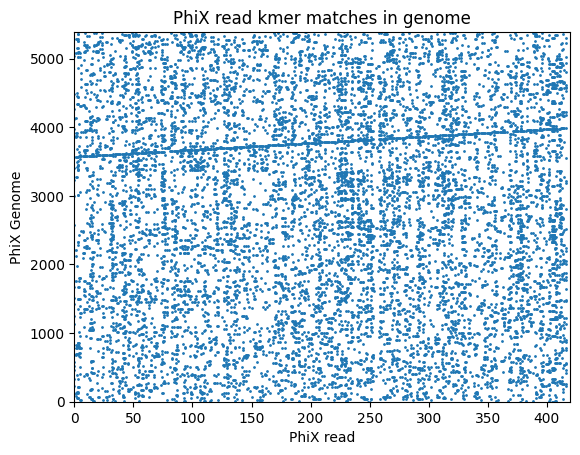

In [61]:
# Let's assign the output of our mapping function to a variable
xy_generator = mapKmers(read = phiX_read.seq, 
                        hash_table = genome_hash_table, 
                        k = 4, 
                        hash_table_size = 500)

# Lists to store x and y values
x_values = []
y_values = []

# Iterate over the generator and extract the x and y values
for x, y in xy_generator:
    x_values.append(x)
    y_values.append(y)

# Create the scatter plot
plt.scatter(x_values, y_values, s=1)
plt.xlim(0, len(phiX_read.seq))
plt.ylim(0, len(phiX_genome.seq))
plt.xlabel('PhiX read')  # Add X-axis label if needed
plt.ylabel('PhiX Genome')  # Add Y-axis label if needed
plt.title('PhiX read kmer matches in genome')
plt.show()

This should look like a right mess! We have used a very small kmer size to compare our read to the genome.



<div class="question">
<h3>Question x</h3>
    
Why do we see kmer matches from our read all over the PhiX genome?


=== BEGIN MARK SCHEME ===

Using a small value of k means that kmer from within our read are also likely to occur elsewhere in the genome.

=== END MARK SCHEME ===

</div>

#### -- GRADED CELL (1 marks) - complete this cell -- 

YOUR ANSWER HERE

Let's rebuild our genome index using a larger value of k to see if we can improve the specificity of our matches.

Remember to increase the size of the hash table to accomodate the extra kmers!

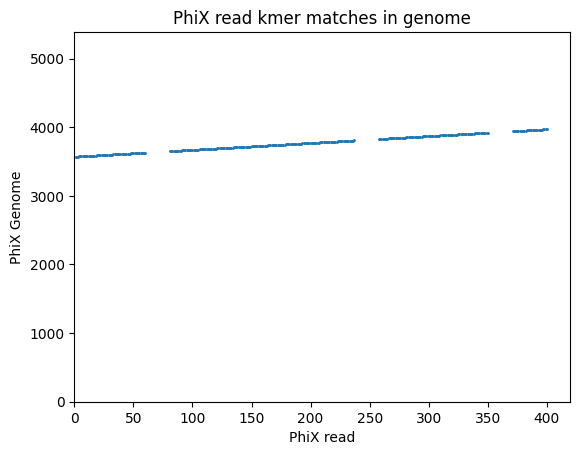

In [66]:
# Increase the size of k to improve the specificity of our read mapping
# You may also need to increase the hash table size to accomodate all the new kmers!
k = 20
table_size = 10000


# Extract kmers and their locations from the PhiX genome
genome_kmers = kmer_locs(phiX_genome.seq, k=k) 
# Note: The phiX_genome is a SeqRecord we need to access the Seq attribute using '.seq'

# Index the PhiX genome using your build_hash_table() function
genome_hash_table = build_hash_table(genome_kmers, hash_table_size = table_size)

# Let's assign the output of our mapping function to a variable
xy_generator = mapKmers(read = phiX_read.seq, 
                        hash_table = genome_hash_table, 
                        k = k, 
                        hash_table_size = table_size )

# Lists to store x and y values
x_values = []
y_values = []

# Iterate over the generator and extract the x and y values
for x, y in xy_generator:
    x_values.append(x)
    y_values.append(y)

# Create the scatter plot
plt.scatter(x_values, y_values, s=1)
plt.xlim(0, len(phiX_read.seq))
plt.ylim(0, len(phiX_genome.seq))
plt.xlabel('PhiX read')  # Add X-axis label if needed
plt.ylabel('PhiX Genome')  # Add Y-axis label if needed
plt.title('PhiX read kmer matches in genome')
plt.show()

<div class="question">
<h3>Question x</h3>
    
Why do we see gaps in the alignment when using longer kmers?


=== BEGIN MARK SCHEME ===

There are errors in the sequencing read. Kmers that include these error are no longer an exact match to the genome and therefore cannot be located in the hash table.

=== END MARK SCHEME ===

</div>

#### -- GRADED CELL (1 marks) - complete this cell -- 

YOUR ANSWER HERE

<div class="question">
<h3>Question x</h3>
    
    
You build a hash table to index kmers of length 10 (10mers). Can you use this index to locate kmers of length 5?

=== BEGIN MARK SCHEME ===

No, a hash table built to index k-mers of a certain length cannot be directly used to look up k-mers of another length.

=== END MARK SCHEME ===

</div>

#### -- GRADED CELL (1 marks) - complete this cell -- 

YOUR ANSWER HERE

<br>

`Workshop developed by Adam Taranto`